In [371]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm_notebook
from operator import itemgetter
import community
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 14})


In [2]:
data1 = pd.read_csv("soc-redditHyperlinks-body.tsv", sep = '\t').drop(columns = ['PROPERTIES', 'POST_ID', 'TIMESTAMP'])
data2 = pd.read_csv("soc-redditHyperlinks-title.tsv", sep = '\t').drop(columns = ['PROPERTIES', 'POST_ID', 'TIMESTAMP'])
print(data1.info())
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286561 entries, 0 to 286560
Data columns (total 3 columns):
SOURCE_SUBREDDIT    286561 non-null object
TARGET_SUBREDDIT    286561 non-null object
LINK_SENTIMENT      286561 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571927 entries, 0 to 571926
Data columns (total 3 columns):
SOURCE_SUBREDDIT    571927 non-null object
TARGET_SUBREDDIT    571927 non-null object
LINK_SENTIMENT      571927 non-null int64
dtypes: int64(1), object(2)
memory usage: 13.1+ MB
None


In [360]:
df = pd.DataFrame(columns=['source', 'target', 'weight'])
df['source'] = data1.SOURCE_SUBREDDIT
df['target'] = data1.TARGET_SUBREDDIT
df['weight'] = data1.LINK_SENTIMENT
df.head()
df.to_csv('copy.csv', index=False)

In [361]:
df = pd.concat([data1, data2])

In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858488 entries, 0 to 571926
Data columns (total 3 columns):
SOURCE_SUBREDDIT    858488 non-null object
TARGET_SUBREDDIT    858488 non-null object
LINK_SENTIMENT      858488 non-null int64
dtypes: int64(1), object(2)
memory usage: 26.2+ MB


In [363]:
np.unique(df.LINK_SENTIMENT, return_counts=True)

(array([-1,  1]), array([ 82210, 776278]))

In [364]:
# get unique subreddits
nodes = (set(df.SOURCE_SUBREDDIT.unique()) | set(df.TARGET_SUBREDDIT.unique()))
print("Number of subreddits :", len(nodes))
# get links 
edges = list(zip(df.SOURCE_SUBREDDIT, df.TARGET_SUBREDDIT, df.LINK_SENTIMENT))
print("Number of links :", len(edges))

Number of subreddits : 67180
Number of links : 858488


In [211]:
with open("nodes.txt", "w") as output:
    output.write(str(nodes))

### sub categories

In [176]:
cats = pd.read_csv("categories.csv", names = ['subreddit', 'category'])
cats =  dict(zip(cats.subreddit, cats.category))

In [365]:
G = nx.MultiDiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

### Degree distribution

In [367]:
import powerlaw

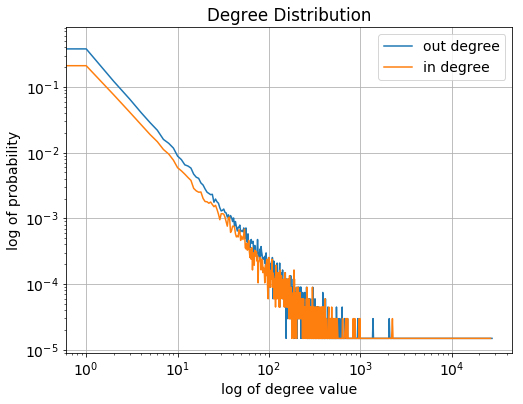

In [373]:
plt.figure(figsize = (8,6))
# vals, counts = np.unique(list(dict(G.degree()).values()), return_counts=True)
# plt.loglog(vals, counts/sum(counts))
plt.title("Degree Distribution")
plt.xlabel('log of degree value')
plt.ylabel('log of probability')
vals, counts = np.unique(list(dict(G.out_degree()).values()), return_counts=True)
plt.loglog(vals, counts/sum(counts), label = "out degree")
vals, counts = np.unique(list(dict(G.in_degree()).values()), return_counts=True)
plt.loglog(vals, counts/sum(counts), label = "in degree")
plt.legend(loc = 0)
plt.savefig("degree_dist.png", dpi = 300)

### Clustering coefficient

In [389]:
#convert to undirected graph with weights
df_simple = neg_df.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'], as_index=False).sum()
print(len(df_simple))
# get unique subreddits
nodes_simple = (set(df_simple.SOURCE_SUBREDDIT.unique()) | set(df_simple.TARGET_SUBREDDIT.unique()))
print("Number of subreddits :", len(nodes_simple))
# get links 
edges_simple = list(zip(df_simple.SOURCE_SUBREDDIT, df_simple.TARGET_SUBREDDIT, df_simple.LINK_SENTIMENT))
print("Number of links :", len(edges_simple))
G_simple = nx.DiGraph()
G_simple.add_nodes_from(nodes_simple)
G_simple.add_weighted_edges_from(edges_simple)
nx.transitivity(G_simple)

41170
Number of subreddits : 12069
Number of links : 41170


0.025335184975769594

### Positive Links

In [386]:
pos_df = df.query('LINK_SENTIMENT==1').reset_index()
pos_df['LINK_SENTIMENT'] = pos_df['LINK_SENTIMENT'].apply(lambda x : abs(x))

In [404]:
# get unique subreddits
pos_nodes = (set(pos_df.SOURCE_SUBREDDIT.unique()) | set(pos_df.TARGET_SUBREDDIT.unique()))
print("Number of subreddits :", len(pos_nodes))
# get links 
pos_edges = list(zip(pos_df.SOURCE_SUBREDDIT, pos_df.TARGET_SUBREDDIT, pos_df.LINK_SENTIMENT))
print("Number of links :", len(pos_edges))

pos_G = nx.MultiDiGraph()
pos_G.add_nodes_from(pos_nodes)
pos_G.add_weighted_edges_from(pos_edges)
appreciators = sorted(pos_G.out_degree, key=itemgetter(1), reverse=True)
appreciated = sorted(pos_G.in_degree, key=itemgetter(1), reverse=True)

Number of subreddits : 65892
Number of links : 776278


### Negative Links

In [391]:
neg_df = df.query('LINK_SENTIMENT==-1').reset_index()
neg_df['LINK_SENTIMENT'] = neg_df['LINK_SENTIMENT'].apply(lambda x : abs(x))

In [392]:
# get unique subreddits
neg_nodes = (set(neg_df.SOURCE_SUBREDDIT.unique()) | set(neg_df.TARGET_SUBREDDIT.unique()))
print("Number of subreddits :", len(neg_nodes))
# get links 
neg_edges = list(zip(neg_df.SOURCE_SUBREDDIT, neg_df.TARGET_SUBREDDIT, neg_df.LINK_SENTIMENT))
print("Number of links :", len(neg_edges))

neg_G = nx.MultiDiGraph()
neg_G.add_nodes_from(neg_nodes)
neg_G.add_weighted_edges_from(neg_edges)
attackers = sorted(neg_G.out_degree, key=itemgetter(1), reverse=True)
attacked = sorted(neg_G.in_degree, key=itemgetter(1), reverse=True)

Number of subreddits : 12069
Number of links : 82210


In [517]:
for val in attacked[0:5]:
    print(val[0],'&',np.round(val[1]*100/len(neg_edges), 3), "\\\\")
    print("\hline")

askreddit & 4.094 \\
\hline
worldnews & 2.073 \\
\hline
news & 1.975 \\
\hline
pics & 1.794 \\
\hline
todayilearned & 1.714 \\
\hline


In [434]:
for val in attackers[0:5]:
    print(val[0],'&',np.round(val[1]*100/len(neg_edges), 3), "\\\\")


subredditdrama & 10.932 \\
bestof & 4.214 \\
drama & 3.272 \\
circlebroke2 & 2.152 \\
shitpost & 1.591 \\


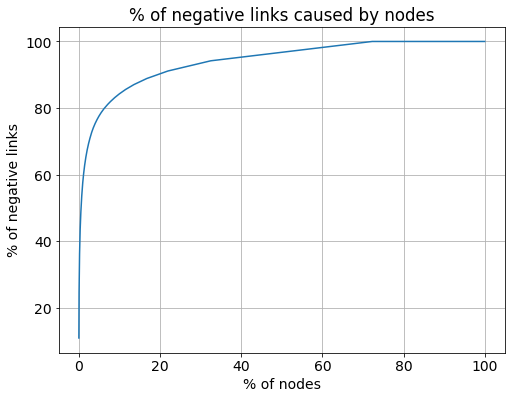

In [410]:
all_negs = np.cumsum([x[1]/len(neg_edges) for x in attackers])
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, len(all_negs))*100/len(all_negs), all_negs*100)
plt.xlabel("% of nodes")
plt.ylabel("% of negative links")
plt.title('% of negative links caused by nodes')
plt.savefig("negativity.png", dpi = 300)

In [84]:
neg_pg = nx.pagerank_scipy(neg_G, weight='weight')
sorted(neg_pg.items(), key = itemgetter(1), reverse=True)

[('askreddit', 0.034184035836843416),
 ('funny', 0.014792081699191413),
 ('pics', 0.014561860108119268),
 ('videos', 0.012419164702013246),
 ('worldnews', 0.012213703373012457),
 ('wtf', 0.010994198816939912),
 ('todayilearned', 0.010970346326865908),
 ('news', 0.009344875246006874),
 ('iama', 0.009246818190330162),
 ('adviceanimals', 0.008440619237302764),
 ('the_donald', 0.008110771148271417),
 ('gaming', 0.007951856568460577),
 ('politics', 0.006938208860730653),
 ('relationships', 0.004990185590724214),
 ('tifu', 0.004853333056539181),
 ('mildlyinteresting', 0.004808724398592535),
 ('gifs', 0.004299061527198546),
 ('explainlikeimfive', 0.004227633324511932),
 ('movies', 0.004219724520107605),
 ('conspiracy', 0.00404382088930942),
 ('science', 0.0037527776983212026),
 ('technology', 0.003716155346654135),
 ('showerthoughts', 0.003656175260073082),
 ('subredditdrama', 0.0035358221132294693),
 ('pokemongo', 0.0034638727811124067),
 ('pcmasterrace', 0.0034456716315508927),
 ('nfl', 0.0

### Full graph

In [263]:
len(G.nodes())

67180

In [45]:
A = nx.adj_matrix(G)
print(np.max(A), np.min(A))
A

548 -25


<67180x67180 sparse matrix of type '<class 'numpy.int64'>'
	with 339643 stored elements in Compressed Sparse Row format>

In [46]:
sorted(G.out_degree, key=itemgetter(1), reverse=True)

[('subredditdrama', 27636),
 ('bestof', 21170),
 ('titlegore', 9503),
 ('shitredditsays', 7839),
 ('drama', 6784),
 ('shitpost', 6658),
 ('circlebroke2', 6583),
 ('switcharoo', 6039),
 ('shitamericanssay', 5963),
 ('hailcorporate', 5360),
 ('shitstatistssay', 4504),
 ('conspiracy', 3850),
 ('shitliberalssay', 3765),
 ('fitnesscirclejerk', 3324),
 ('badphilosophy', 3021),
 ('the_donald', 2749),
 ('circlebroke', 2640),
 ('gamingcirclejerk', 2532),
 ('notcirclejerk', 2460),
 ('theydidthemath', 2412),
 ('evenwithcontext', 2383),
 ('topmindsofreddit', 2346),
 ('botsrights', 2314),
 ('srssucks', 2211),
 ('thebluepill', 2137),
 ('retiredgif', 2104),
 ('gaming', 2072),
 ('enoughlibertarianspam', 2072),
 ('anarcho_capitalism', 2045),
 ('shitpoliticssays', 2003),
 ('outoftheloop', 1959),
 ('bitcoin', 1955),
 ('japancirclejerk', 1948),
 ('dogecoin', 1903),
 ('copypasta', 1824),
 ('depthhub', 1791),
 ('writingprompts', 1707),
 ('television', 1584),
 ('badlinguistics', 1549),
 ('circlejerkcopypasta

In [47]:
sorted(G.in_degree, key=itemgetter(1), reverse=True)

[('askreddit', 26622),
 ('iama', 13446),
 ('pics', 12578),
 ('todayilearned', 11124),
 ('funny', 10777),
 ('videos', 10013),
 ('worldnews', 9944),
 ('news', 7692),
 ('politics', 6114),
 ('gaming', 6097),
 ('adviceanimals', 5503),
 ('wtf', 5320),
 ('gifs', 5214),
 ('writingprompts', 5056),
 ('leagueoflegends', 4856),
 ('science', 4557),
 ('the_donald', 4487),
 ('showerthoughts', 4202),
 ('bitcoin', 4028),
 ('nfl', 4000),
 ('conspiracy', 3950),
 ('movies', 3883),
 ('explainlikeimfive', 3790),
 ('soccer', 3775),
 ('pcmasterrace', 3702),
 ('technology', 3530),
 ('subredditdrama', 3507),
 ('mildlyinteresting', 3349),
 ('tifu', 3186),
 ('nba', 3042),
 ('hockey', 2962),
 ('aww', 2929),
 ('sandersforpresident', 2845),
 ('relationships', 2712),
 ('europe', 2676),
 ('dota2', 2591),
 ('android', 2494),
 ('legaladvice', 2372),
 ('atheism', 2369),
 ('books', 2324),
 ('music', 2278),
 ('askhistorians', 2273),
 ('dogecoin', 2245),
 ('kotakuinaction', 2245),
 ('games', 2200),
 ('twoxchromosomes', 2188

In [48]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.00019022197856924137


In [49]:
print("Strongly connected components : ",len(list(nx.strongly_connected_components(G))))
print("Weakly connected components : ",len(list(nx.weakly_connected_components(G))))

Strongly connected components :  45564
Weakly connected components :  712


### PageRank Centrality - subreddits that are most important 

In [436]:
pg = nx.pagerank_scipy(G)

In [439]:
for x in sorted(pg.items(), key = itemgetter(1), reverse=True)[0:10]:
    print("\hline")
    print(x[0], "&", np.round(x[1], 3), "\\\\")

\hline
askreddit & 0.021 \\
\hline
iama & 0.018 \\
\hline
pics & 0.011 \\
\hline
funny & 0.009 \\
\hline
videos & 0.009 \\
\hline
todayilearned & 0.006 \\
\hline
gaming & 0.006 \\
\hline
worldnews & 0.005 \\
\hline
science & 0.004 \\
\hline
news & 0.004 \\


### Closeness centrality

### Reciprocity

In [448]:
('againstlovesubreddits', 'againsthatesubreddits') in G.edges

False

In [466]:
neg_r = reciprocity(neg_G, nodes = neg_G.nodes)

In [471]:
neg_r_data = [(sb[0], sb[1], neg_G.degree(sb[0])) for sb in sorted(neg_r.items(), key = itemgetter(1), reverse=True)]
for x in sorted(neg_r_data, key = itemgetter(1), reverse=False)[0:5]:
    print("\hline")
    print(x[0], "&", np.round(x[1], 3), "\\\\")
print("\hline")

\hline
dredmorbius & 0.0 \\
\hline
againstlovesubreddits & 0.0 \\
\hline
tkmorcambe & 0.0 \\
\hline
cybercock & 0.0 \\
\hline
pillowforts & 0.0 \\
\hline


In [515]:
plt.figure(figsize=(8,6))
vals, counts = np.unique(list(neg_r.values()), return_counts=True)
zipped = list(zip(vals, counts/sum(counts)))
print([x for x in zipped if x[0]==1])
print([x for x in zipped if x[0]==0.0])
countdf = pd.DataFrame(columns=['value'])
countdf.value = vals
print(countdf.describe())
# plt.plot((vals), (counts/sum(counts)))
# plt.xlim([-0.001, 0.2])

[(1.0, 0.006214267959234402)]
[(0.0, 0.916065954097274)]
            value
count  257.000000
mean     0.138051
std      0.134096
min      0.000000
25%      0.050000
50%      0.101266
75%      0.167939
max      1.000000


<Figure size 576x432 with 0 Axes>

            value
count  257.000000
mean     0.138051
std      0.134096
min      0.000000
25%      0.050000
50%      0.101266
75%      0.167939
max      1.000000


In [501]:
pos_r = reciprocity(pos_G, nodes = pos_G.nodes)

In [503]:
pos_r_data = [(sb[0], sb[1], pos_G.degree(sb[0])) for sb in sorted(pos_r.items(), key = itemgetter(1), reverse=True)]
for x in sorted(pos_r_data, key = itemgetter(1), reverse=True)[0:5]:
    print("\hline")
    print(x[0], "&", np.round(x[1], 3), "\\\\")
print("\hline")

\hline
newwhitehaven & 1.0 \\
\hline
mrref & 1.0 \\
\hline
dungeonscape & 1.0 \\
\hline
kommunitykombat & 1.0 \\
\hline
privatepracticeslps & 1.0 \\
\hline


In [514]:
vals, counts = np.unique(list(pos_r.values()), return_counts=True)
zipped = list(zip(vals, counts/sum(counts)))
print([x for x in zipped if x[0]==1])
print([x for x in zipped if x[0]==0.0])
countdf = pd.DataFrame(columns=['value'])
countdf.value = vals
print(countdf.describe())

[(1.0, 0.0286681235961877)]
[(0.0, 0.7881836945304438)]
             value
count  1279.000000
mean      0.236884
std       0.165132
min       0.000000
25%       0.116548
50%       0.211921
75%       0.309396
max       1.000000


In [510]:
for x in zipped:
    if(x[0]==0):
        print("yes")

In [350]:
counts

array([51935,     1,     1, ...,     1,     1,  1889])

# Clustering 

In [127]:
#convert to undirected graph with weights
df1 = df.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'], as_index=False).sum()
print(len(df1))
# get unique subreddits
nodes1 = (set(df1.SOURCE_SUBREDDIT.unique()) | set(df1.TARGET_SUBREDDIT.unique()))
print("Number of subreddits :", len(nodes1))
# get links 
edges1 = list(zip(df1.SOURCE_SUBREDDIT, df1.TARGET_SUBREDDIT, abs(df1.LINK_SENTIMENT)))
print("Number of links :", len(edges1))
G1 = nx.Graph()
G1.add_nodes_from(nodes1)
G1.add_weighted_edges_from(edges1)

339643
Number of subreddits : 67180
Number of links : 339643


In [131]:
G2 = list(G1.subgraph(c) for c in nx.connected_components(G1))[0]

In [134]:
partition = community.best_partition(G2, weight='weight')

In [154]:
comms = max(list(partition.values()))+1
communities = dict.fromkeys(range(comms))
len_communities = dict.fromkeys(range(comms))

for comm in communities:
    communities[comm] = []
for node in partition:
    communities[partition[node]].append(node)
for comm in communities:
    len_communities[comm] = len(communities[comm])

In [359]:
len(communities)

246

In [157]:
sorted(len_communities.items(), key = itemgetter(1), reverse=True)

[(4, 10966),
 (9, 8615),
 (6, 8398),
 (22, 3412),
 (12, 3365),
 (14, 2996),
 (3, 2615),
 (23, 2474),
 (15, 2053),
 (8, 1995),
 (2, 1846),
 (11, 1626),
 (20, 1549),
 (16, 1381),
 (18, 1296),
 (10, 1219),
 (5, 1051),
 (19, 926),
 (24, 866),
 (33, 775),
 (27, 764),
 (17, 641),
 (21, 526),
 (29, 515),
 (0, 481),
 (28, 435),
 (34, 435),
 (25, 428),
 (26, 337),
 (7, 215),
 (1, 210),
 (30, 207),
 (43, 163),
 (13, 153),
 (39, 104),
 (35, 96),
 (32, 43),
 (44, 39),
 (51, 34),
 (31, 29),
 (56, 27),
 (81, 23),
 (45, 17),
 (48, 16),
 (61, 13),
 (50, 7),
 (71, 7),
 (102, 6),
 (54, 5),
 (40, 4),
 (60, 4),
 (67, 4),
 (108, 4),
 (114, 4),
 (42, 3),
 (49, 3),
 (59, 3),
 (62, 3),
 (65, 3),
 (96, 3),
 (99, 3),
 (100, 3),
 (101, 3),
 (109, 3),
 (134, 3),
 (141, 3),
 (145, 3),
 (175, 3),
 (37, 2),
 (55, 2),
 (69, 2),
 (106, 2),
 (118, 2),
 (139, 2),
 (156, 2),
 (186, 2),
 (36, 1),
 (38, 1),
 (41, 1),
 (46, 1),
 (47, 1),
 (52, 1),
 (53, 1),
 (57, 1),
 (58, 1),
 (63, 1),
 (64, 1),
 (66, 1),
 (68, 1),
 (70, 1